# Hücre 1 — Import + Path

In [8]:
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODELS_DIR = os.path.join(BASE_DIR, "models")
sys.path.insert(0, MODELS_DIR)

from relu_se_resnet_tiny import TinySE_ResNet_ReLU
from silu_se_resnet_tiny import TinySE_ResNet_SiLU
from leakyrelu_se_resnet_tiny import TinySE_ResNet_LeakyReLU
from prelu_se_resnet_tiny import TinySE_ResNet_PReLU

print("BASE_DIR  :", BASE_DIR)
print("MODELS_DIR:", MODELS_DIR)

BASE_DIR  : c:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Core
MODELS_DIR: c:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Core\models


# Hücre 2 — Seed + Device


In [9]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

# Hücre 3 — Dataset / DataLoader

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 128
NUM_CLASSES = 10

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(test_loader)

100%|██████████| 170M/170M [00:44<00:00, 3.87MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(391, 79)

# Hücre 4 — Train / Eval fonksiyonları

In [ ]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total, correct = 0, 0
    loss_sum = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return loss_sum / total, correct / total


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_sum = 0.0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x.size(0)
        total += x.size(0)

    return loss_sum / total

# Hücre 5 — Modelleri oluştur + adil init (aynı Conv/BN/FC)

In [12]:
EPOCHS = 15
LR = 1e-3

set_seed(42)

relu  = TinySE_ResNet_ReLU(num_classes=NUM_CLASSES).to(device)
silu  = TinySE_ResNet_SiLU(num_classes=NUM_CLASSES).to(device)
lrelu = TinySE_ResNet_LeakyReLU(num_classes=NUM_CLASSES, negative_slope=0.1).to(device)
prelu = TinySE_ResNet_PReLU(num_classes=NUM_CLASSES, prelu_init=0.25).to(device)

# Aynı başlangıç: Conv/BN/FC birebir aynı olsun
silu.load_state_dict(relu.state_dict(), strict=True)
lrelu.load_state_dict(relu.state_dict(), strict=True)
prelu.load_state_dict(relu.state_dict(), strict=False)  # PReLU extra param (a)

opt_relu  = optim.Adam(relu.parameters(),  lr=LR)
opt_silu  = optim.Adam(silu.parameters(),  lr=LR)
opt_lrelu = optim.Adam(lrelu.parameters(), lr=LR)
opt_prelu = optim.Adam(prelu.parameters(), lr=LR)

print("Models ready.")

Models ready.


# Hücre 6 — Eğitim döngüsü + log

In [13]:
history = {
    "relu":  {"tr": [], "teL": [], "teA": []},
    "silu":  {"tr": [], "teL": [], "teA": []},
    "lrelu": {"tr": [], "teL": [], "teA": []},
    "prelu": {"tr": [], "teL": [], "teA": []},
}

for epoch in range(1, EPOCHS + 1):
    tr_relu  = train_one_epoch(relu,  train_loader, opt_relu,  device)
    teL_relu,  teA_relu  = evaluate(relu,  test_loader, device)

    tr_silu  = train_one_epoch(silu,  train_loader, opt_silu,  device)
    teL_silu, teA_silu  = evaluate(silu,  test_loader, device)

    tr_lrelu  = train_one_epoch(lrelu, train_loader, opt_lrelu, device)
    teL_lrelu, teA_lrelu = evaluate(lrelu, test_loader, device)

    tr_prelu  = train_one_epoch(prelu, train_loader, opt_prelu, device)
    teL_prelu, teA_prelu = evaluate(prelu, test_loader, device)

    history["relu"]["tr"].append(tr_relu);   history["relu"]["teL"].append(teL_relu);   history["relu"]["teA"].append(teA_relu)
    history["silu"]["tr"].append(tr_silu);   history["silu"]["teL"].append(teL_silu);   history["silu"]["teA"].append(teA_silu)
    history["lrelu"]["tr"].append(tr_lrelu); history["lrelu"]["teL"].append(teL_lrelu); history["lrelu"]["teA"].append(teA_lrelu)
    history["prelu"]["tr"].append(tr_prelu); history["prelu"]["teL"].append(teL_prelu); history["prelu"]["teA"].append(teA_prelu)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"ReLU:  train_loss={tr_relu:.4f} test_loss={teL_relu:.4f} acc={teA_relu:.4f} | "
        f"SiLU:  train_loss={tr_silu:.4f} test_loss={teL_silu:.4f} acc={teA_silu:.4f} | "
        f"LReLU: train_loss={tr_lrelu:.4f} test_loss={teL_lrelu:.4f} acc={teA_lrelu:.4f} | "
        f"PReLU: train_loss={tr_prelu:.4f} test_loss={teL_prelu:.4f} acc={teA_prelu:.4f}"
    )

Epoch 01/15 | ReLU:  train_loss=1.5592 test_loss=1.3858 acc=0.5107 | SiLU:  train_loss=1.6056 test_loss=1.4505 acc=0.4837 | LReLU: train_loss=1.5791 test_loss=1.3302 acc=0.5125 | PReLU: train_loss=1.5997 test_loss=1.3937 acc=0.4907
Epoch 02/15 | ReLU:  train_loss=1.1770 test_loss=1.1066 acc=0.6092 | SiLU:  train_loss=1.2246 test_loss=1.0981 acc=0.6075 | LReLU: train_loss=1.2059 test_loss=1.1987 acc=0.5742 | PReLU: train_loss=1.2503 test_loss=1.3372 acc=0.5403
Epoch 03/15 | ReLU:  train_loss=1.0027 test_loss=1.0119 acc=0.6467 | SiLU:  train_loss=1.0342 test_loss=1.0429 acc=0.6311 | LReLU: train_loss=1.0369 test_loss=1.0041 acc=0.6403 | PReLU: train_loss=1.0630 test_loss=1.2787 acc=0.5855
Epoch 04/15 | ReLU:  train_loss=0.8897 test_loss=0.9620 acc=0.6630 | SiLU:  train_loss=0.9254 test_loss=0.8809 acc=0.6917 | LReLU: train_loss=0.9311 test_loss=1.0267 acc=0.6497 | PReLU: train_loss=0.9470 test_loss=1.0434 acc=0.6412
Epoch 05/15 | ReLU:  train_loss=0.8036 test_loss=0.8753 acc=0.6962 | SiL

# Hücre 7 — Grafik (Accuracy)

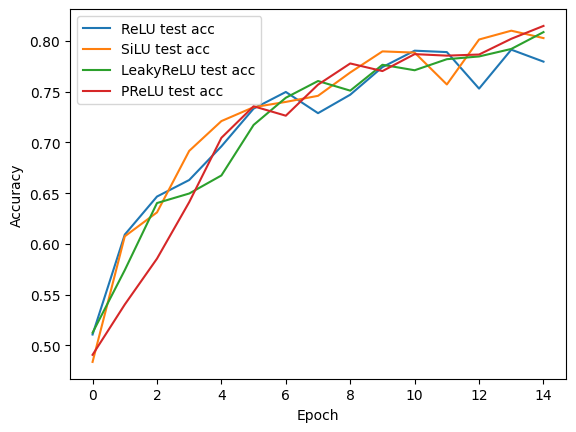

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["relu"]["teA"],  label="ReLU test acc")
plt.plot(history["silu"]["teA"],  label="SiLU test acc")
plt.plot(history["lrelu"]["teA"], label="LeakyReLU test acc")
plt.plot(history["prelu"]["teA"], label="PReLU test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Hücre 8 — Grafik (Test Loss)

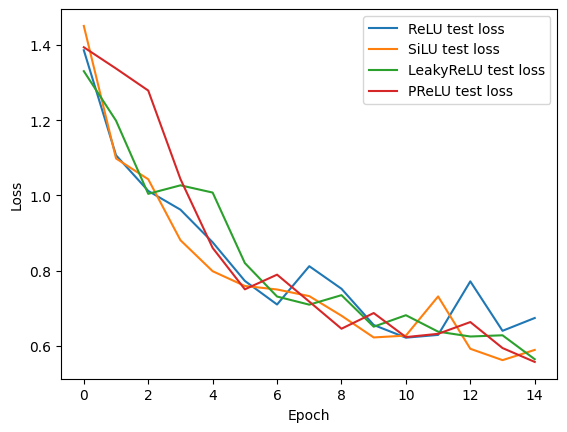

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["relu"]["teL"],  label="ReLU test loss")
plt.plot(history["silu"]["teL"],  label="SiLU test loss")
plt.plot(history["lrelu"]["teL"], label="LeakyReLU test loss")
plt.plot(history["prelu"]["teL"], label="PReLU test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Hücre 9 — Final özet

In [16]:
print("Final (last epoch):")
for k in ["relu", "silu", "lrelu", "prelu"]:
    print(f"{k.upper():5s} | acc={history[k]['teA'][-1]:.4f}, loss={history[k]['teL'][-1]:.4f}")

Final (last epoch):
RELU  | acc=0.7797, loss=0.6740
SILU  | acc=0.8029, loss=0.5892
LRELU | acc=0.8088, loss=0.5645
PRELU | acc=0.8149, loss=0.5573


## 🔍 Aktivasyon Fonksiyonları Karşılaştırması

**Deney Ayarları (özet):**
- Epoch: 15  
- Aynı model, aynı eğitim koşulları  
- Metrik: Test Accuracy (acc) ve Test Loss  

| Activation | En İyi Accuracy (Peak) | Son Epoch Accuracy | Son Test Loss | Eğitim Davranışı | Genel Yorum |
|-----------|------------------------|--------------------|---------------|------------------|-------------|
| **ReLU** | 0.7905 (Ep11) | 0.7797 | 0.6740 | Sonlara doğru dalgalanma ve düşüş | Basit ve hızlı ancak bu deneyde genelleme zayıf |
| **SiLU** | 0.8102 (Ep14) | 0.8029 | 0.5892 | Orta epochlarda belirgin dalgalanma | Daha yumuşak gradyan, ancak stabilite hassas |
| **LeakyReLU** | 0.8088 (Ep15) | 0.8088 | 0.5645 | Genel olarak dengeli ve düzgün | Parametresiz ve stabil, deploy için uygun |
| **PReLU** | **0.8149 (Ep15)** | **0.8149** | **0.5573** | Finalde güçlü toparlanma | En iyi performans, az ek parametre maliyeti |


## 🧠 Genel Değerlendirme

Bu deney sonuçlarına göre **PReLU**, hem en yüksek doğruluğu hem de en düşük test loss değerini sağlayarak performans açısından öne çıkmaktadır.  
**LeakyReLU**, parametresiz yapısı ve daha stabil eğitim davranışı sayesinde hız ve dağıtım (deployment) odaklı senaryolar için güçlü bir alternatiftir.  
**SiLU**, bazı epochlarda dalgalı davranış sergilediğinden bu kurulumda stabilite açısından daha hassas görünmektedir.  
**ReLU** ise basitliğine rağmen bu deneyde diğer aktivasyonlara kıyasla daha zayıf genelleme performansı göstermiştir.

**Sonuç:**  
Bu koşullar altında doğruluk öncelikli projelerde **PReLU**, hız ve sadelik öncelikli projelerde ise **LeakyReLU** tercih edilmelidir.
